In [2]:
#!pip install tensorflow==1.14.0

In [3]:
#!pip install keras==2.2.5

In [4]:
import os
os.environ["PYTHONHASHSEED"] = "13"
os.environ["CUDA_VISIBLE_DEVICES"] = "0:1"

import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(13)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(13)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(13)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [5]:
import gc
import warnings

#import lightgbm as lgb
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm

import keras
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout

path_data = "../input/ashrae-energy-prediction/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = path_data + "building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

myfavouritenumber = 13
seed = myfavouritenumber

warnings.filterwarnings("ignore")

In [6]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5021578597200525306
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15898309957366372341
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14200497421349292829
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14941647668
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10437139698159636797
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5"
]


In [8]:
site_id = 9

In [9]:
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

building = pd.read_csv(path_building)

weather_train = pd.read_csv(path_weather_train)
weather_test = pd.read_csv(path_weather_test)

weather_train.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)
weather_test.drop(["sea_level_pressure", "wind_direction", "wind_speed"], axis=1, inplace=True)

weather_train = weather_train.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))
weather_test = weather_test.groupby("site_id").apply(lambda group: group.interpolate(limit_direction="both"))

df_train = df_train.merge(building, on="building_id")
df_test = df_test.merge(building, on="building_id")

df_train = df_train[df_train.site_id == site_id]
df_test = df_test[df_test.site_id == site_id]

df_train = df_train[~((df_train.meter_reading == 0) & (df_train.meter.isin([0, 1])))]
df_train = df_train[df_train.meter == 0]

df_train = df_train.merge(weather_train, on=["site_id", "timestamp"], how="left")
df_test = df_test.merge(weather_test, on=["site_id", "timestamp"], how="left")

df_train.timestamp = pd.to_datetime(df_train.timestamp, format='%Y-%m-%d %H:%M:%S')
df_test.timestamp = pd.to_datetime(df_test.timestamp, format='%Y-%m-%d %H:%M:%S')

df_train.building_id = df_train.building_id.astype("str")
df_test.building_id = df_test.building_id.astype("str")

df_train["log_meter_reading"] = np.log1p(df_train.meter_reading)

del building
gc.collect()

148

In [10]:
df_train["hour"] = df_train.timestamp.dt.hour.astype("str")
df_test["hour"] = df_test.timestamp.dt.hour.astype("str")

df_train["weekday"] = df_train.timestamp.dt.weekday.astype("str")
df_test["weekday"] = df_test.timestamp.dt.weekday.astype("str")

df_train["month"] = df_train.timestamp.dt.month.astype("str")
df_test["month"] = df_test.timestamp.dt.month.astype("str")

In [11]:
features = [
    "building_id",
    "square_feet",
    "year_built",
    "floor_count",
    "primary_use",
    "air_temperature",
    "cloud_coverage",
    "dew_temperature",
    "precip_depth_1_hr",
    "hour",
    "weekday",
    "month"
]

In [12]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [13]:
cv = 5
folds = KFold(n_splits = cv, shuffle = False, random_state = seed)

df_cv = []
df_preds = []

Building Model for site_id 9 and meter 0
Preparing Site: 9 , meter: 0 , Fold: 1



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 819169 samples, validate on 204793 samples
Epoch 1/21


 - 34s - loss: 1.9481 - val_loss: 0.9977
Epoch 2/21
 - 9s - loss: 1.3210 - val_loss: 0.9799
Epoch 3/21
 - 9s - loss: 1.2993 - val_loss: 0.9659
Epoch 4/21
 - 9s - loss: 1.2780 - val_loss: 0.9460
Epoch 5/21
 - 9s - loss: 1.2575 - val_loss: 0.9295
Epoch 6/21
 - 9s - loss: 1.2395 - val_loss: 0.9213
Epoch 7/21
 - 9s - loss: 1.2239 - val_loss: 0.9043
Epoch 8/21
 - 9s - loss: 1.2100 - val_loss: 0.8959
Epoch 9/21
 - 9s - loss: 1.1958 - val_loss: 0.8865
Epoch 10/21
 - 9s - loss: 1.1829 - val_loss: 0.8885
Epoch 11/21
 - 9s - loss: 1.1714 - val_loss: 0.8795
Epoch 12/21
 - 9s - loss: 1.1609 - val_loss: 0.8825
Epoch 13/21
 - 9s - loss: 1.1502 - 

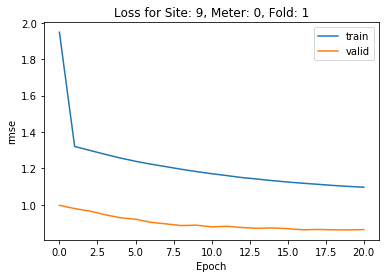

CPU times: user 58 s, sys: 3.39 s, total: 1min 1s
Wall time: 46.9 s
Preparing Site: 9 , meter: 0 , Fold: 2
Train on 819169 samples, validate on 204793 samples
Epoch 1/21
 - 10s - loss: 1.8518 - val_loss: 0.9931
Epoch 2/21
 - 9s - loss: 1.3248 - val_loss: 0.9585
Epoch 3/21
 - 9s - loss: 1.3015 - val_loss: 0.9520
Epoch 4/21
 - 9s - loss: 1.2811 - val_loss: 0.9270
Epoch 5/21
 - 9s - loss: 1.2629 - val_loss: 0.9146
Epoch 6/21
 - 9s - loss: 1.2462 - val_loss: 0.9040
Epoch 7/21
 - 9s - loss: 1.2324 - val_loss: 0.9073
Epoch 8/21
 - 9s - loss: 1.2185 - val_loss: 0.9034
Epoch 9/21
 - 9s - loss: 1.2043 - val_loss: 0.8867
Epoch 10/21
 - 9s - loss: 1.1935 - val_loss: 0.8889
Epoch 11/21
 - 9s - loss: 1.1820 - val_loss: 0.8822
Epoch 12/21
 - 9s - loss: 1.1732 - val_loss: 0.8818
Epoch 13/21
 - 9s - loss: 1.1629 - val_loss: 0.8701
Epoch 14/21
 - 9s - loss: 1.1551 - val_loss: 0.8829
Epoch 15/21
 - 9s - loss: 1.1477 - val_loss: 0.8710
Epoch 16/21
 - 9s - loss: 1.1410 - val_loss: 0.8672
Epoch 17/21
 - 9s

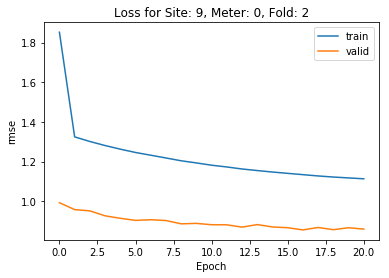

CPU times: user 59.4 s, sys: 3.64 s, total: 1min 3s
Wall time: 48.6 s
Preparing Site: 9 , meter: 0 , Fold: 3
Train on 819170 samples, validate on 204792 samples
Epoch 1/21
 - 10s - loss: 1.7635 - val_loss: 1.4452
Epoch 2/21
 - 9s - loss: 1.2168 - val_loss: 1.4055
Epoch 3/21
 - 9s - loss: 1.1868 - val_loss: 1.3778
Epoch 4/21
 - 9s - loss: 1.1605 - val_loss: 1.3445
Epoch 5/21
 - 9s - loss: 1.1372 - val_loss: 1.3307
Epoch 6/21
 - 9s - loss: 1.1161 - val_loss: 1.3205
Epoch 7/21
 - 9s - loss: 1.0965 - val_loss: 1.3014
Epoch 8/21
 - 9s - loss: 1.0789 - val_loss: 1.2880
Epoch 9/21
 - 9s - loss: 1.0620 - val_loss: 1.2738
Epoch 10/21
 - 9s - loss: 1.0475 - val_loss: 1.2693
Epoch 11/21
 - 9s - loss: 1.0336 - val_loss: 1.2776
Epoch 12/21
 - 9s - loss: 1.0219 - val_loss: 1.2695
Epoch 13/21
 - 9s - loss: 1.0110 - val_loss: 1.2674
Epoch 14/21
 - 9s - loss: 1.0013 - val_loss: 1.2659
Epoch 15/21
 - 9s - loss: 0.9920 - val_loss: 1.2648
Epoch 16/21
 - 9s - loss: 0.9834 - val_loss: 1.2627
Epoch 17/21
 - 

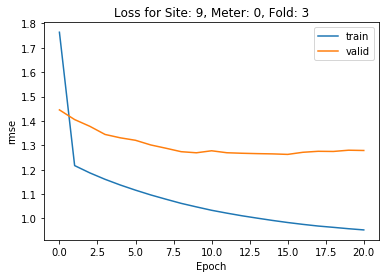

CPU times: user 1min 2s, sys: 3.73 s, total: 1min 6s
Wall time: 52 s
Preparing Site: 9 , meter: 0 , Fold: 4
Train on 819170 samples, validate on 204792 samples
Epoch 1/21
 - 10s - loss: 1.8691 - val_loss: 1.1440
Epoch 2/21
 - 9s - loss: 1.3225 - val_loss: 1.1000
Epoch 3/21
 - 9s - loss: 1.2985 - val_loss: 1.0864
Epoch 4/21
 - 9s - loss: 1.2779 - val_loss: 1.0358
Epoch 5/21
 - 9s - loss: 1.2585 - val_loss: 1.0363
Epoch 6/21
 - 9s - loss: 1.2425 - val_loss: 1.0092
Epoch 7/21
 - 9s - loss: 1.2254 - val_loss: 1.0052
Epoch 8/21
 - 9s - loss: 1.2108 - val_loss: 1.0013
Epoch 9/21
 - 9s - loss: 1.1987 - val_loss: 0.9984
Epoch 10/21
 - 9s - loss: 1.1865 - val_loss: 0.9850
Epoch 11/21
 - 9s - loss: 1.1756 - val_loss: 0.9673
Epoch 12/21
 - 9s - loss: 1.1644 - val_loss: 0.9655
Epoch 13/21
 - 9s - loss: 1.1549 - val_loss: 0.9761
Epoch 14/21
 - 9s - loss: 1.1463 - val_loss: 0.9683
Epoch 15/21
 - 9s - loss: 1.1379 - val_loss: 0.9577
Epoch 16/21
 - 9s - loss: 1.1303 - val_loss: 0.9645
Epoch 17/21
 - 9

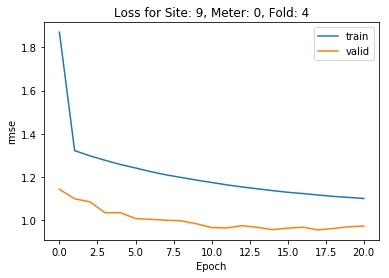

CPU times: user 1min 4s, sys: 3.5 s, total: 1min 8s
Wall time: 53.9 s
Preparing Site: 9 , meter: 0 , Fold: 5
Train on 819170 samples, validate on 204792 samples
Epoch 1/21
 - 11s - loss: 1.9019 - val_loss: 0.8887
Epoch 2/21
 - 9s - loss: 1.3665 - val_loss: 0.8697
Epoch 3/21
 - 9s - loss: 1.3437 - val_loss: 0.8307
Epoch 4/21
 - 9s - loss: 1.3243 - val_loss: 0.8094
Epoch 5/21
 - 9s - loss: 1.3056 - val_loss: 0.7912
Epoch 6/21
 - 9s - loss: 1.2891 - val_loss: 0.7895
Epoch 7/21
 - 9s - loss: 1.2747 - val_loss: 0.7850
Epoch 8/21
 - 9s - loss: 1.2608 - val_loss: 0.7926
Epoch 9/21
 - 9s - loss: 1.2467 - val_loss: 0.7846
Epoch 10/21
 - 9s - loss: 1.2341 - val_loss: 0.7959
Epoch 11/21
 - 9s - loss: 1.2230 - val_loss: 0.7940
Epoch 12/21
 - 9s - loss: 1.2127 - val_loss: 0.7842
Epoch 13/21
 - 9s - loss: 1.2029 - val_loss: 0.7897
Epoch 14/21
 - 9s - loss: 1.1939 - val_loss: 0.7947
Epoch 15/21
 - 9s - loss: 1.1858 - val_loss: 0.7843
Epoch 16/21
 - 9s - loss: 1.1775 - val_loss: 0.7983
Epoch 17/21
 - 

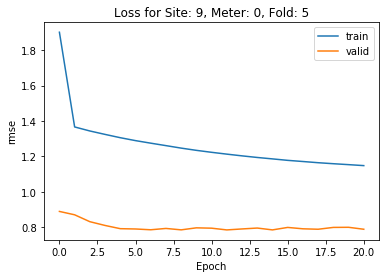

CPU times: user 1min 13s, sys: 5.07 s, total: 1min 18s
Wall time: 1min 7s

CV RMSE for Site: 9 and Meter: 0 is 1.1121915739395294

CV RMSE for Site: 9 is 1.1121915739395294


In [14]:
for meter in df_train.meter.unique():
    print("Building Model for site_id", site_id, "and meter", meter)
        
    df_train_site_meter = df_train[df_train.meter == meter].reset_index(drop=True)
    df_test_site_meter = df_test[df_test.meter == meter].reset_index(drop=True)
    
    pred_val = np.zeros(df_train_site_meter.shape[0])
    pred_test = np.zeros(df_test_site_meter.shape[0])

    row_ids_test = df_test_site_meter.row_id
    y_train_site_meter = df_train_site_meter.log_meter_reading.values
    
    df_train_site_meter = df_train_site_meter[features]
    df_test_site_meter = df_test_site_meter[features]

    df_train_site_meter = pd.get_dummies(df_train_site_meter)
    df_test_site_meter = pd.get_dummies(df_test_site_meter)
        
    for k, (train_idx, valid_idx) in enumerate(folds.split(df_train_site_meter, y_train_site_meter)):
        print("Preparing Site:", site_id, ", meter:", meter, ", Fold:", k+1)
        
        X_train, y_train = df_train_site_meter.iloc[train_idx], y_train_site_meter[train_idx]
        X_valid, y_valid = df_train_site_meter.iloc[valid_idx], y_train_site_meter[valid_idx]
        
        X_train.dropna(axis=1, how="all", inplace=True)
        X_train = X_train.loc[:, (X_train != X_train.iloc[0]).any()]

        X_valid = X_valid[X_train.columns]
        X_test = df_test_site_meter[X_train.columns]
        
        df_means = pd.concat([X_train, X_valid, X_test], ignore_index=True).mean()
        X_train.fillna(df_means, inplace=True)
        X_valid.fillna(df_means, inplace=True)
        X_test.fillna(df_means, inplace=True)
        
        sc = MinMaxScaler()
        sc.fit(pd.concat([X_train, X_valid, X_test], ignore_index=True))
        
        X_train = np.array(sc.transform(X_train))
        X_valid = np.array(sc.transform(X_valid))
        X_test = np.array(sc.transform(X_test))
        
        model = Sequential()
        model.add(Dense(256, input_dim=X_train.shape[1], activation="relu", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(64, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(8, activation="tanh", kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss=rmse, optimizer="adam")
        
        model_ffnn = model.fit(X_train, y_train, epochs=21, batch_size=500, validation_data=(X_valid, y_valid), verbose=2, shuffle=False)

        plt.plot(model_ffnn.history["loss"])
        plt.plot(model_ffnn.history["val_loss"])
        plt.title("Loss for Site: " + str(site_id) + ", Meter: " + str(meter) + ", Fold: " + str(k+1))
        plt.ylabel("rmse")
        plt.xlabel("Epoch")
        plt.legend(["train", "valid"], loc="upper right")
        plt.show()
        
        pred_val[valid_idx] = model.predict(X_valid).ravel()
        %time pred_test += model.predict(X_test).ravel() / cv
        
        gc.collect()
        
    df_valid = pd.DataFrame({"site_id": site_id, "meter": meter, "meter_reading": np.expm1(y_train_site_meter), "pred_ffnn": np.clip(np.expm1(pred_val), 0, a_max=None)})
    df_pred = pd.DataFrame({"row_id": row_ids_test, "meter_reading": np.clip(np.expm1(pred_test), 0, a_max=None)})
    
    df_cv.append(df_valid)
    df_preds.append(df_pred)
    
    gc.collect()
    
    print("\nCV RMSE for Site:", site_id, "and Meter:", meter, "is", np.sqrt(mean_squared_error(np.log1p(df_valid.meter_reading), np.log1p(df_valid.pred_ffnn))))

df_cv = pd.concat(df_cv)
print("\nCV RMSE for Site:", site_id, "is", np.sqrt(mean_squared_error(np.log1p(df_cv.meter_reading), np.log1p(df_cv.pred_ffnn))))


In [15]:
df_preds = pd.concat(df_preds)
df_preds.to_csv("../sub/ffnn_pred_site_" + str(site_id) + ".csv", index=False)